<a href="https://www.kaggle.com/code/masatakasuzuki/two-feature-importance-split-and-gain?scriptVersionId=120513100" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction
In this notebook, I will check the difference between train and test data distribution.

And check two feature importance of lightgbm, split and gain.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.model_selection import KFold, cross_validate

import lightgbm as lgb

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e8/sample_submission.csv
/kaggle/input/playground-series-s3e8/train.csv
/kaggle/input/playground-series-s3e8/test.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e8/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e8/test.csv')
train_df.drop(columns='id', inplace=True)
test_df.drop(columns='id', inplace=True)

The means of each columns is below. (If you want to know more about the data, See: [Feature Descriptions to help you engineer better features.](https://www.kaggle.com/competitions/playground-series-s3e8/discussion/389213), [Girdle feature and possible mistake in the documentation?](https://www.kaggle.com/competitions/playground-series-s3e8/discussion/389743))

| column name | mean |
| --- | --- |
| carat | weight of the cubic zirconia |
| cut | cut quality of the cubic zirconia. Best to Worst: Ideal > Premium > Very Good > Good > Fair |
| color | color of the cubic zirconia. Best to Worst: D > E > F > G > H > I > J . (KOSH shared helpful information. check the [link](https://www.kaggle.com/competitions/playground-series-s3e8/discussion/389589) and upvote it.|
| clarity | the absence of the inclusions and blemishes.  Best to Worst: FL > IF > VVS1 > VVS2 > VS1 > VS2 > SI1 > SI2 > I1 > I2 > I3 |
| depth | the height of the cubic zirconia |
| table | the width of the cubic zirconia |
| x | length of the cubic zirconia in mm |
| y | height of the cubic zirconia in mm |
| z | width of the cubic zirconia in mm |
| price | price of the cubic zirconia. This is target column. |

Firstly, let's check null value.

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193573 entries, 0 to 193572
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   carat    193573 non-null  float64
 1   cut      193573 non-null  object 
 2   color    193573 non-null  object 
 3   clarity  193573 non-null  object 
 4   depth    193573 non-null  float64
 5   table    193573 non-null  float64
 6   x        193573 non-null  float64
 7   y        193573 non-null  float64
 8   z        193573 non-null  float64
 9   price    193573 non-null  int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 14.8+ MB


In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129050 entries, 0 to 129049
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   carat    129050 non-null  float64
 1   cut      129050 non-null  object 
 2   color    129050 non-null  object 
 3   clarity  129050 non-null  object 
 4   depth    129050 non-null  float64
 5   table    129050 non-null  float64
 6   x        129050 non-null  float64
 7   y        129050 non-null  float64
 8   z        129050 non-null  float64
dtypes: float64(6), object(3)
memory usage: 8.9+ MB


Great. There is no null value. Let's check the distribution next. 

In [5]:
# preprocessing
cut_labeling = {col: val for val, col in enumerate(['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'])}
color_labeling = {col: val for val, col in enumerate(['J', 'I', 'H', 'G', 'F', 'E', 'D'])}
clarity_labeling = {col: val for val, col in enumerate(
    ['I3', 'I2', 'I1', 'SI2', 'SI1', 'VVS2', 'VVS1', 'VS2', 'VS1', 'IF', 'FL'])}
# to preprocess label features, map label to integer number.
def preprocessing(df):
    df['cut'] = df['cut'].map(cut_labeling)
    df['color'] = df['color'].map(color_labeling)
    df['clarity'] = df['clarity'].map(clarity_labeling)
    return df

In [6]:
train_df = preprocessing(train_df)
test_df = preprocessing(test_df)

In [7]:
train_df['is_train'] = 1
test_df['is_train'] = 0
all_df = pd.concat([train_df, test_df], axis=0)

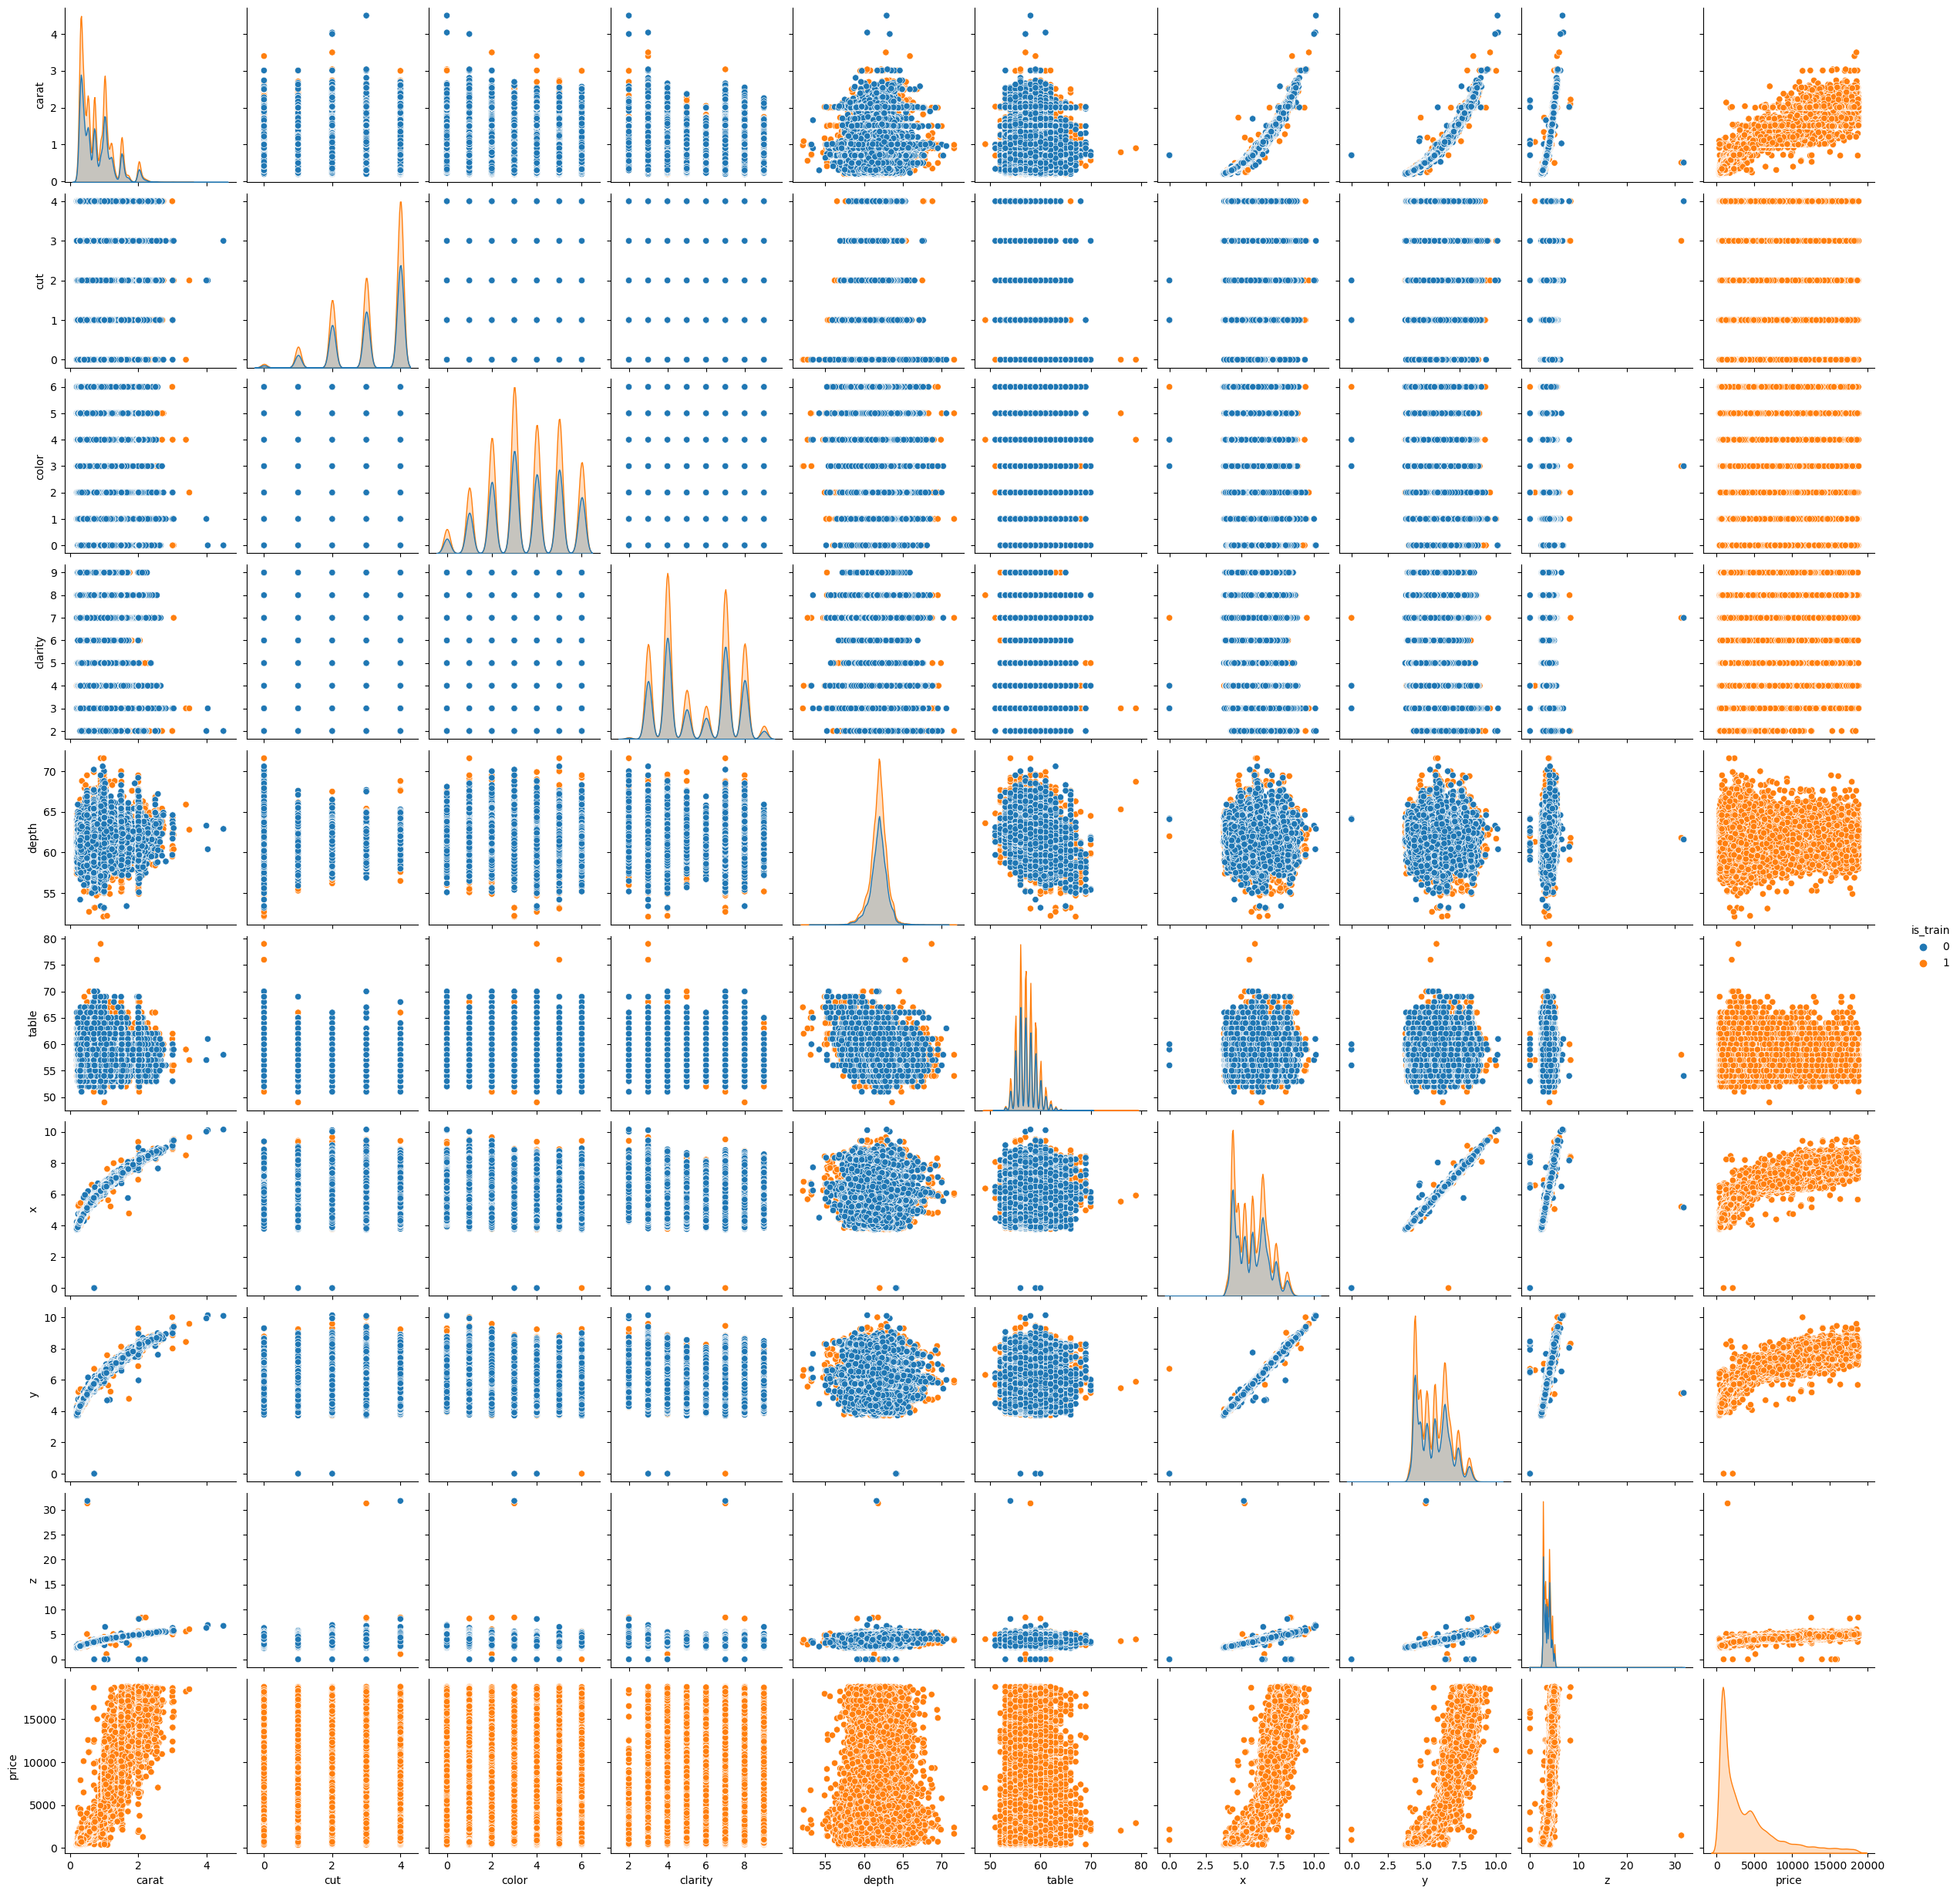

In [8]:
sns.pairplot(all_df, hue='is_train')

The orange data is in train_df and blue data is in test_df. Both distribution is almost same.

As you see, "price" depends on "carat", "x", "y" and "z" and does not depend on "depth" and "table". "x", "y" and "z" is correlated each other.

In [9]:
train_df.drop(columns='is_train', inplace=True)

<AxesSubplot:>

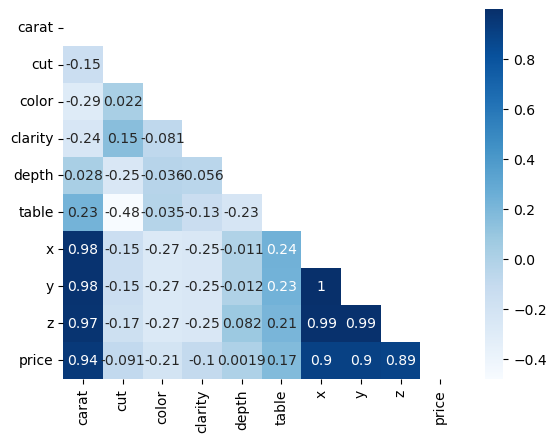

In [10]:
corr = train_df.corr()
mask = np.zeros_like(corr)
mask[np.tril_indices_from(mask)] = True
sns.heatmap(corr, cmap='Blues', annot=True, mask=mask.T)

# Feature Engineering and Fit Model

In [11]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e8/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e8/test.csv')
train_df.drop(columns='id', inplace=True)
test_df.drop(columns='id', inplace=True)

In [12]:
def preprocessing(df):
    cut_labeling = {col: val for val, col in enumerate(['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'])}
    color_labeling = {col: val for val, col in enumerate(['J', 'I', 'H', 'G', 'F', 'E', 'D'])}
    clarity_labeling = {col: val for val, col in enumerate(
    ['I3', 'I2', 'I1', 'SI2', 'SI1', 'VVS2', 'VVS1', 'VS2', 'VS1', 'IF', 'FL'])}
    # to preprocess label features, map label to integer number.
    df['cut'] = df['cut'].map(cut_labeling)
    df['color'] = df['color'].map(color_labeling)
    df['clarity'] = df['clarity'].map(clarity_labeling)
    # transform x, y, z
    df['volume'] = df['x'] * df['y'] * df['z']
    df['top_surface'] = df['x'] * df['y']
    df['z_xy'] = df['z'] / (df['x'] * df['y'] + 1e-6)
    df['density'] = df['carat'] / (df['volume'] + 1e-6)
    df['table_percentage'] = (df['table'] / ((df['x'] + df['y']) / 2)) * 100
    df['depth_percentage'] = (df['depth'] / ((df['x'] + df['y']) / 2)) * 100
    df['symmetry'] = (abs(df['x'] - df['z']) + abs(df['y'] - df['z'])) / (df['x'] + df['y'] + df['z'])
    df['surface_area'] = 2 * ((df['x'] * df['y']) + (df['x'] * df['z']) + (df['y'] * df['z']))
    df['depth_to_table_ratio'] = df['depth'] / (df['table'] + 1e-6)
    df['depth_per_volume'] = df['depth'] / (df['volume'] + 1e-6)
    df['depth_per_density'] = df['depth'] / (df['density'] + 1e-6)
    df['depth_per_table'] = df['depth'] / (df['table'] + 1e-6)
    return df

In [13]:
train_df = preprocessing(train_df)
train_df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price,...,z_xy,density,table_percentage,depth_percentage,symmetry,surface_area,depth_to_table_ratio,depth_per_volume,depth_per_density,depth_per_table
0,1.52,3,4,7,62.2,58.0,7.27,7.33,4.55,13619,...,0.085383,0.006269,794.520548,852.054795,0.287206,239.4382,1.072414,0.256531,9920.357177,1.072414
1,2.03,2,0,3,62.0,58.0,8.06,8.12,5.05,13387,...,0.077161,0.006142,716.934487,766.378245,0.286387,294.3124,1.068965,0.187590,10092.700818,1.068965
2,0.70,4,3,8,61.2,57.0,5.69,5.73,3.50,2772,...,0.107350,0.006134,998.248687,1071.803853,0.296247,145.1474,1.073684,0.536311,9975.106161,1.073684
3,0.32,4,3,8,61.6,56.0,4.38,4.41,2.71,666,...,0.140300,0.006113,1274.175199,1401.592719,0.293043,86.2734,1.100000,1.176789,10074.922095,1.100000
4,1.70,3,3,7,62.6,59.0,7.65,7.61,4.77,14453,...,0.081936,0.006122,773.263434,820.445609,0.285572,262.0134,1.061017,0.225429,10223.955457,1.061017


In [14]:
feature_col = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z', 'top_surface', 'z_xy', 'volume', 'density', 'table_percentage', 'depth_percentage', 'symmetry', 'surface_area', 'depth_to_table_ratio', 'depth_per_volume', 'depth_per_density', 'depth_per_table']
# feature_col = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'top_surface', 'z_xy', 'volume']

train_x = train_df[feature_col]
train_y = train_df['price']

In [15]:
lgb_params = {
    'objective': 'regression',
    'metric': 'mse',
}
kf = KFold(n_splits=10, shuffle=True, random_state=8)
model = lgb.LGBMRegressor(**lgb_params, importance_type='split')
scores = cross_validate(model, X=train_x, y=train_y, scoring='neg_root_mean_squared_error', cv=kf, return_estimator=True)

In [16]:
scores

{'fit_time': array([2.8683455 , 2.65541196, 2.65764189, 2.76211214, 2.82490349,
        2.76408315, 2.77605391, 3.16504478, 3.27808619, 3.05588865]),
 'score_time': array([0.05213737, 0.05198193, 0.05050087, 0.05381703, 0.0526855 ,
        0.05309129, 0.05634022, 0.06987166, 0.0538342 , 0.05241418]),
 'estimator': [LGBMRegressor(metric='mse', objective='regression'),
  LGBMRegressor(metric='mse', objective='regression'),
  LGBMRegressor(metric='mse', objective='regression'),
  LGBMRegressor(metric='mse', objective='regression'),
  LGBMRegressor(metric='mse', objective='regression'),
  LGBMRegressor(metric='mse', objective='regression'),
  LGBMRegressor(metric='mse', objective='regression'),
  LGBMRegressor(metric='mse', objective='regression'),
  LGBMRegressor(metric='mse', objective='regression'),
  LGBMRegressor(metric='mse', objective='regression')],
 'test_score': array([-589.77075371, -558.09428432, -579.68677272, -587.39290189,
        -577.93420994, -596.45516878, -573.66321936,


- split: How many time the feature is used
- gain: How the objective function decreases by the feature

<AxesSubplot:>

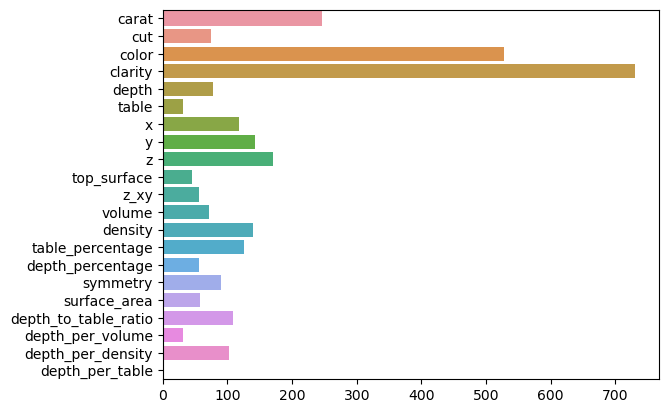

In [17]:
feature_names = scores['estimator'][0].feature_name_
feature_importances = np.mean([model.feature_importances_ for model in scores['estimator']], axis=0)
sns.barplot(x=feature_importances, y=feature_names, orient='h')

As you see, `carat`, `color` and `clarity`  is used to predict more than other features.

In [18]:
kf = KFold(n_splits=10, shuffle=True, random_state=8)
model = lgb.LGBMRegressor(**lgb_params, importance_type='gain')
scores = cross_validate(model, X=train_x, y=train_y, scoring='neg_root_mean_squared_error', cv=kf, return_estimator=True)

In [19]:
scores

{'fit_time': array([2.92583799, 2.75220895, 2.79921508, 2.88291907, 2.64652967,
        2.70647049, 2.66434431, 2.73774505, 3.62917709, 2.69512057]),
 'score_time': array([0.05216432, 0.05386758, 0.05145288, 0.05528712, 0.0546453 ,
        0.05186009, 0.05324483, 0.053689  , 0.05423331, 0.05241275]),
 'estimator': [LGBMRegressor(importance_type='gain', metric='mse', objective='regression'),
  LGBMRegressor(importance_type='gain', metric='mse', objective='regression'),
  LGBMRegressor(importance_type='gain', metric='mse', objective='regression'),
  LGBMRegressor(importance_type='gain', metric='mse', objective='regression'),
  LGBMRegressor(importance_type='gain', metric='mse', objective='regression'),
  LGBMRegressor(importance_type='gain', metric='mse', objective='regression'),
  LGBMRegressor(importance_type='gain', metric='mse', objective='regression'),
  LGBMRegressor(importance_type='gain', metric='mse', objective='regression'),
  LGBMRegressor(importance_type='gain', metric='mse',

<AxesSubplot:>

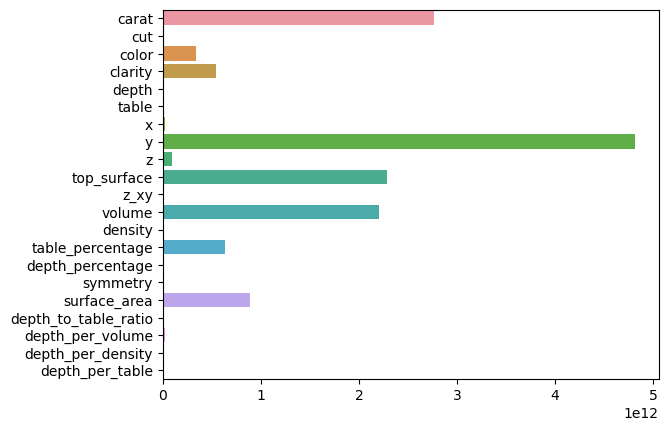

In [20]:
feature_names = scores['estimator'][0].feature_name_
feature_importances = np.mean([model.feature_importances_ for model in scores['estimator']], axis=0)
sns.barplot(x=feature_importances, y=feature_names, orient='h')

When the feature is used to predict, `carat`, `y` and `top_surface` are more effective than other features.

# Submit

In [21]:
test_df = pd.read_csv('/kaggle/input/playground-series-s3e8/test.csv')
test_df = preprocessing(test_df)
test_x = test_df[feature_col]

In [22]:
# take mean of 10 estimator
y_pred = np.mean([model.predict(test_x) for model in scores['estimator'] ], axis=0)

In [23]:
submission_df = pd.read_csv('/kaggle/input/playground-series-s3e8/sample_submission.csv', index_col='id')
submission_df['price'] = y_pred
submission_df.to_csv('submission.csv')